In [1]:
#chamada 
#if __name__ == '__main__':
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import itertools    


from sklearn import model_selection
from keras.optimizers import SGD
from keras.optimizers import Adam
from collections import Counter
#vamos importar as classes para realizar o random RandomOverSampler e SMOTE
from imblearn.over_sampling import RandomOverSampler, SMOTE



from tqdm import tqdm
from keras import metrics
from keras.utils import np_utils
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

2024-07-02 10:12:36.662384: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
#Devido o conjunto de dados ser muito grande, não será possível enviar junto ao arquivo.Link para baixar o conjunto de dados abaixo 
#--> http://205.174.165.80/IOTDataset/CIC_IOT_Dataset2023/

In [2]:
checkpoint_callback_normal = ModelCheckpoint(
    filepath='melhor_modelo1_normal.h5', #caminho para salvar o arquivo do modelo
    monitor='val_loss', #métrica a ser monitorada
    save_best_only=True, #salvar apenas o melhor modelo
    save_weights_only=False, #salvar o nodelo completo incluindo a arquitetura
    mode='min', #salvar o modelo com a menor perda de validação
    verbose=1  # Modo de verbosidade (0 ou 1)
    
)
checkpoint_callback_sampli = ModelCheckpoint(
    filepath='melhor_modelo1_sampli.h5', #caminho para salvar o arquivo do modelo
    monitor='val_loss', #métrica a ser monitorada
    save_best_only=True, #salvar apenas o melhor modelo
    save_weights_only=False, #salvar o nodelo completo incluindo a arquitetura
    mode='min', #salvar o modelo com a menor perda de validação
    verbose=1  # Modo de verbosidade (0 ou 1)
    
)

checkpoint_callback_modelsmote = ModelCheckpoint(
    filepath='melhor_modelo1_smote.h5', #caminho para salvar o arquivo do modelo
    monitor='val_loss', #métrica a ser monitorada
    save_best_only=True, #salvar apenas o melhor modelo
    save_weights_only=False, #salvar o nodelo completo incluindo a arquitetura
    mode='min', #salvar o modelo com a menor perda de validação
    verbose=1  # Modo de verbosidade (0 ou 1)
    
)

checkpoint_callback_normal_melhoria_final = ModelCheckpoint(
    filepath='melhor_modelo1_normal_melhoria_final.h5', #caminho para salvar o arquivo do modelo
    monitor='val_loss', #métrica a ser monitorada
    save_best_only=True, #salvar apenas o melhor modelo
    save_weights_only=False, #salvar o nodelo completo incluindo a arquitetura
    mode='min', #salvar o modelo com a menor perda de validação
    verbose=1  # Modo de verbosidade (0 ou 1)
)

callback_stop_patience = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

#função de callbackt
class Mycallback(tf.keras.callbacks.Callback):
    def on_epochs_end(self, epoch, logs={}):
        if logs.get('accuracy') > 1.0:
            print('accuracy: 100%, vamos cancelar o treino! Essa condição já nos satisfaz!')
            self.model.stop_training = True
            

In [3]:
#vamos definir as métricas de avaliação
metricas = [
    metrics.FalseNegatives(name="fn"),
    metrics.FalsePositives(name="fp"),
    metrics.TrueNegatives(name="Tn"),
    metrics.TruePositives(name="Tp"),
    metrics.Precision(name="precision"),
    metrics.Recall(name="recall"),
    
]

2024-07-02 10:12:39.382530: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
dict_7classes = {}
dict_7classes['DDoS-RSTFINFlood'] = 'DDoS'
dict_7classes['DDoS-PSHACK_Flood'] = 'DDoS'
dict_7classes['DDoS-SYN_Flood'] = 'DDoS'
dict_7classes['DDoS-UDP_Flood'] = 'DDoS'
dict_7classes['DDoS-TCP_Flood'] = 'DDoS'
dict_7classes['DDoS-ICMP_Flood'] = 'DDoS'
dict_7classes['DDoS-SynonymousIP_Flood'] = 'DDoS'
dict_7classes['DDoS-ACK_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-UDP_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-ICMP_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-SlowLoris'] = 'DDoS'
dict_7classes['DDoS-HTTP_Flood'] = 'DDoS'

dict_7classes['DoS-UDP_Flood'] = 'DoS'
dict_7classes['DoS-SYN_Flood'] = 'DoS'
dict_7classes['DoS-TCP_Flood'] = 'DoS'
dict_7classes['DoS-HTTP_Flood'] = 'DoS'


dict_7classes['Mirai-greeth_flood'] = 'Mirai'
dict_7classes['Mirai-greip_flood'] = 'Mirai'
dict_7classes['Mirai-udpplain'] = 'Mirai'

dict_7classes['Recon-PingSweep'] = 'Recon'
dict_7classes['Recon-OSScan'] = 'Recon'
dict_7classes['Recon-PortScan'] = 'Recon'
dict_7classes['VulnerabilityScan'] = 'Recon'
dict_7classes['Recon-HostDiscovery'] = 'Recon'

dict_7classes['DNS_Spoofing'] = 'Spoofing'
dict_7classes['MITM-ArpSpoofing'] = 'Spoofing'

dict_7classes['BenignTraffic'] = 'Benign'

dict_7classes['BrowserHijacking'] = 'Web'
dict_7classes['Backdoor_Malware'] = 'Web'
dict_7classes['XSS'] = 'Web'
dict_7classes['Uploading_Attack'] = 'Web'
dict_7classes['SqlInjection'] = 'Web'
dict_7classes['CommandInjection'] = 'Web'


dict_7classes['DictionaryBruteForce'] = 'BruteForce'

In [5]:
def smote_class(X,y):
    print("Distribuição original:", Counter(y))
    #aplicando a técnica de SMOTE
    smote = SMOTE(random_state=42)
    X_smot, y_smot = smote.fit_resample(X,y)
    print("Distribuição SMOTE:", Counter(y_smot))
    return X_smot, y_smot

def RandomOver_class(X, y):
    print("Distribuição original:", Counter(y))
    ros = RandomOverSampler(random_state=42)
    X_Roversampling, y_roversampling = ros.fit_resample(X,y)
    return X_Roversampling, y_roversampling


In [6]:
def plotagem_dados(y):
    #contagem das classes
    data = Counter(y)
    #adicionando os valores de cada classe em uma lista
    counts = list(data.values())

    #nomes das categorias
    category_names = ['DDoS',
             'DoS',
             'Mirai',
             'Benign',
             'Spoofing',
             'Recon',
             'Web',
             'BruteForce'] 
    #craindo a figura
    plt.figure(figsize=(10,6))

    plt.bar(category_names, counts, color=['red','green','blue'])
    plt.xlabel('Categoria dos Ataques')
    plt.ylabel('Números de Ataques')
    plt.title('Ataques IoT')
    plt.show()

In [7]:
def preprocessing():
    DATASET_DIRECTORY = 'CICIoT2023'
    #dataset k.endswith('.csv') -> pega somente os arquivos que terminam com .csv
    data_set = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
    data_set_n = sorted(data_set)
    #pegando os dados de train
    training_sets = data_set_n[:int(len(data_set_n)*0.8)]
    #pegando os dados de test
    test_sets = data_set_n[int(len(data_set_n)*0.8):]


    
    #dados de test
    for test in test_sets:
        path = DATASET_DIRECTORY+'/'+test
        test = pd.read_csv(path)
        new_y_test = [dict_7classes[k] for k in test['label']]
        y_test = new_y_test
        X_test = test.drop('label', axis=1)
        

    for train in training_sets:
        path = DATASET_DIRECTORY+'/'+train
        train = pd.read_csv(path)
        new_y_train = [dict_7classes[k] for k in train['label']]
        y_train = new_y_train
        X_train = train.drop('label', axis=1)



    #plotagem dos dados normais
    plotagem_dados(y_train)
    #igualando os dados com técnica simples
    X_train_sampling, y_train_sampling = RandomOver_class(X_train, y_train)
    plotagem_dados(y_train_sampling)

    #utilizando SMOTE
    X_train_smote, y_train_smote = smote_class(X_train, y_train)
    plotagem_dados(y_train_smote)

    
    #transformar dados de treino
    X_train_normalizador = MinMaxScaler()
    X_train = X_train_normalizador.fit_transform(X_train)
 
    labelencoder_train  = LabelEncoder()
    y_train = labelencoder_train.fit_transform(y_train)
    y_train = np_utils.to_categorical(y_train)

        
    #transformar dados de treino sampling
    X_train_sampling_normalizador = MinMaxScaler()
    X_train_sampling = X_train_sampling_normalizador.fit_transform(X_train_sampling)
    

    labelencoder_train  = LabelEncoder()
    y_train_sampling = labelencoder_train.fit_transform(y_train_sampling)
    y_train_sampling = np_utils.to_categorical(y_train_sampling)

        
    #transformar dados de treino smote
    X_train_smote_normalizador = MinMaxScaler()
    X_train_smote = X_train_smote_normalizador.fit_transform(X_train_smote)
    

    labelencoder_train  = LabelEncoder()
    y_train_smote = labelencoder_train.fit_transform(y_train_smote)
    y_train_smote = np_utils.to_categorical(y_train_smote)
    

    
    #transformar dados de teste entre 0 e 1
    X_test_normalizador = MinMaxScaler()
    X_test = X_test_normalizador.fit_transform(X_test)
    
    #transformar em números inteiros
    labelencoder_teste = LabelEncoder()
    y_test = labelencoder_teste.fit_transform(y_test)
    #transformação em  vetores binários
    y_test = np_utils.to_categorical(y_test)

 


    return X_train, y_train, X_train_sampling, y_train_sampling, X_train_smote, y_train_smote, X_test, y_test

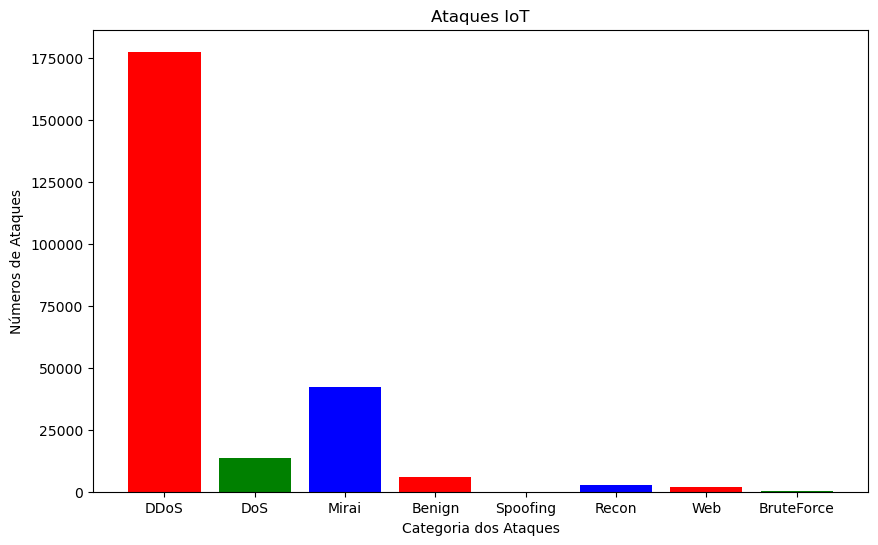

Distribuição original: Counter({'DDoS': 177426, 'DoS': 42363, 'Mirai': 13595, 'Benign': 5738, 'Spoofing': 2532, 'Recon': 1790, 'Web': 136, 'BruteForce': 69})


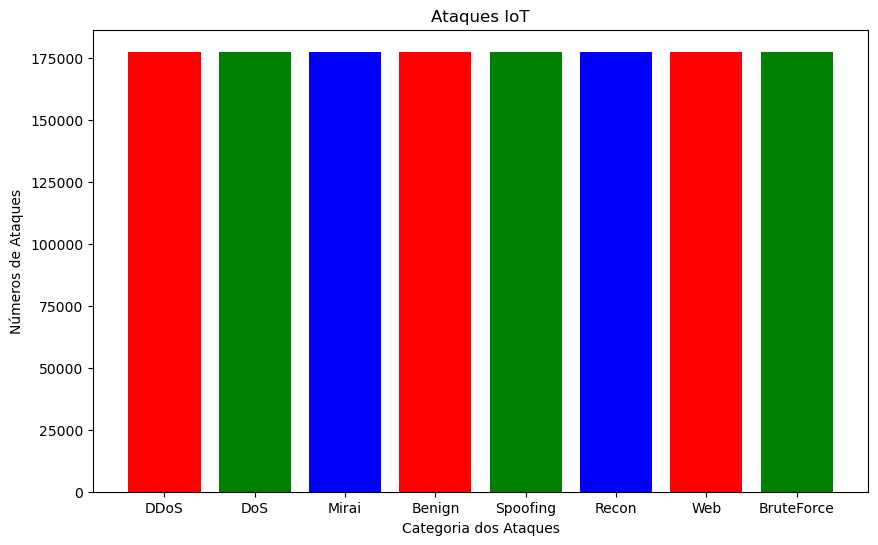

Distribuição original: Counter({'DDoS': 177426, 'DoS': 42363, 'Mirai': 13595, 'Benign': 5738, 'Spoofing': 2532, 'Recon': 1790, 'Web': 136, 'BruteForce': 69})
Distribuição SMOTE: Counter({'DDoS': 177426, 'Mirai': 177426, 'DoS': 177426, 'Benign': 177426, 'BruteForce': 177426, 'Spoofing': 177426, 'Recon': 177426, 'Web': 177426})


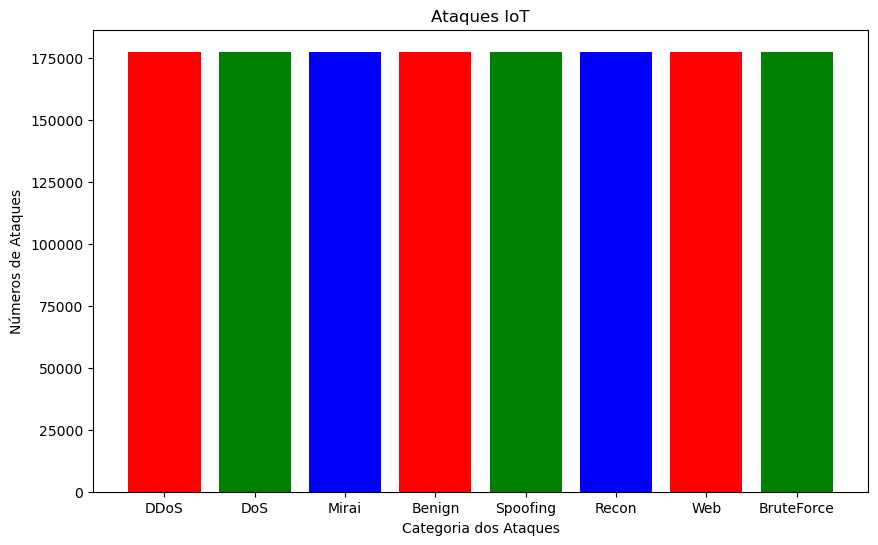

In [8]:
X_train, y_train, X_train_sampling, y_train_sampling, X_train_smote, y_train_smote, X_test, y_test_dump = preprocessing()

In [10]:
X_train_sampling, X_validation_sampling, y_train_sampling, y_validation_sampling = model_selection.train_test_split(X_train_sampling, y_train_sampling,
                                                            test_size=0.2, random_state=1, stratify=y_train_sampling)

In [11]:
X_train_smote, X_validation_smote, y_train_smote, y_validation_smote = model_selection.train_test_split(X_train_smote, y_train_smote,test_size=0.3, random_state=1, stratify=y_train_smote)



In [9]:

X_train, X_validation, y_train, y_validation = model_selection.train_test_split(X_train, y_train,test_size=0.3, random_state=1, stratify=y_train)



In [10]:
def modeloDenseoficial(X_train, metricas):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(500, activation="relu", input_shape=(X_train.shape[-1],)),
        tf.keras.layers.Dense(units=500, activation='relu', kernel_initializer="random_uniform", bias_initializer="random_uniform"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=500, activation='relu', kernel_initializer="random_uniform", bias_initializer="random_uniform"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(8,activation='softmax')
        
    ])
    model.compile(loss='categorical_crossentropy',optimizer=Adam(1e-3), metrics=metricas)
    return model


In [50]:
def modeloDense(X_train, metricas):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(500, activation="relu", input_shape=(X_train.shape[-1],)),
        tf.keras.layers.Dense(units=500, activation='relu', kernel_initializer="random_uniform", bias_initializer="random_uniform"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=500, activation='relu', kernel_initializer="random_uniform", bias_initializer="random_uniform"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(8,activation='softmax')
        
    ])
    model.compile(loss='categorical_crossentropy',optimizer=Adam(0.001), metrics=metricas)
    return model

In [51]:
model_nor = modeloDense(X_train,metricas)
model_normal = model_nor.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                  batch_size=200, epochs=200, verbose=1, callbacks=[Mycallback(), checkpoint_callback_normal_melhoria_final,
                                                                    callback_stop_patience])


Epoch 1/200
1704/1706 [============================>.] - ETA: 0s - loss: 0.3850 - fn: 42513.0000 - fp: 38354.0000 - Tn: 1666111.0000 - Tp: 200982.0000 - precision: 0.8397 - recall: 0.8254
Epoch 1: val_loss did not improve from 0.26775
1706/1706 [==============================] - 21s 12ms/step - loss: 0.3850 - fn: 42545.0000 - fp: 38386.0000 - Tn: 1667157.0000 - Tp: 201104.0000 - precision: 0.8397 - recall: 0.8254 - val_loss: 0.3543 - val_fn: 12516.0000 - val_fp: 12051.0000 - val_Tn: 499614.0000 - val_Tp: 60579.0000 - val_precision: 0.8341 - val_recall: 0.8288
Epoch 2/200
1706/1706 [==============================] - ETA: 0s - loss: 0.3487 - fn: 28889.0000 - fp: 27302.0000 - Tn: 1166576.0000 - Tp: 141665.0000 - precision: 0.8384 - recall: 0.8306
Epoch 2: val_loss did not improve from 0.26775
1706/1706 [==============================] - 31s 18ms/step - loss: 0.3487 - fn: 28889.0000 - fp: 27302.0000 - Tn: 1166576.0000 - Tp: 141665.0000 - precision: 0.8384 - recall: 0.8306 - val_loss: 0.340

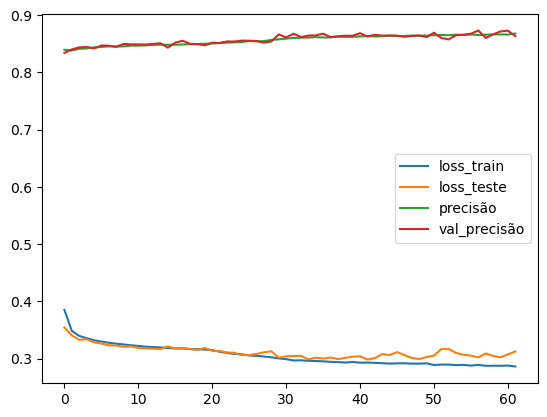

In [52]:
plt.plot(model_normal.history["loss"], label="loss_train")
plt.plot(model_normal.history["val_loss"], label="loss_teste")
plt.plot(model_normal.history["precision"], label="precisão")
plt.plot(model_normal.history["val_precision"], label="val_precisão")
#plt.plot(history.history["tp"], label="tp")
#plt.plot(history.history["val_tp"], label="val_tp")
plt.legend()

In [53]:

TrainPredictions = model_nor.predict(X_test)
#convertendo dados onehot encoder para rotulos de classes
TrainPredictions_convert_samply = np.argmax(TrainPredictions, axis=1)
y_train_rotulos_samply = np.argmax(y_test_dump, axis=1)

7336/7336 [==============================] - 13s 2ms/step


Text(0.5, 23.52222222222222, 'Predicted label')

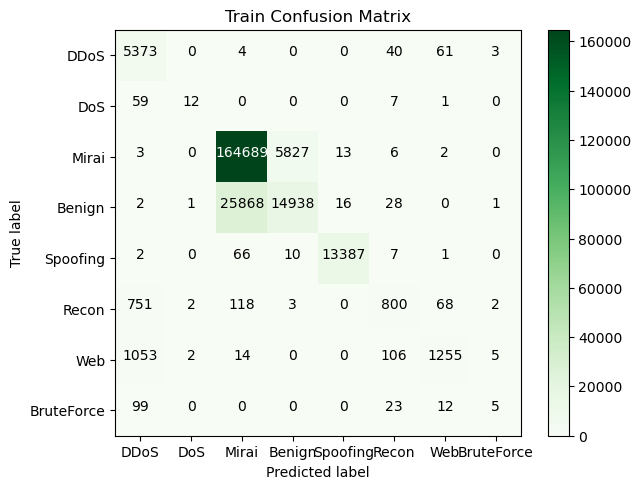

In [56]:
conf = confusion_matrix(y_train_rotulos_samply, TrainPredictions_convert_samply)

classes = ['DDoS', 'DoS','Mirai','Benign','Spoofing','Recon','Web','BruteForce']
#classes = [0,1,2,3,4,5,6,7]
#plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Train Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [57]:
print('Confusion Matrix\n')
print(conf)
#Micro: Foca no total agregado de verdadeiros positivos, falsos negativos e falsos positivos. Cada instância conta igualmente.
#importar as métricas 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(f'Accuracy: {accuracy_score(y_train_rotulos_samply, TrainPredictions_convert_samply)}\n')
print(f"Micro Precision: {precision_score(y_train_rotulos_samply, TrainPredictions_convert_samply, average='micro')}\n")
print(f"Micro Recall: {recall_score(y_train_rotulos_samply, TrainPredictions_convert_samply, average='micro')}\n")
print(f'Micro F1_score: {f1_score(y_train_rotulos_samply, TrainPredictions_convert_samply, average="micro")}\n')

#Macro: Calcula a métrica para cada classe individualmente e tira a média aritmética. Cada classe conta igualmente.
print(f'Macro Precision: {precision_score(y_train_rotulos_samply, TrainPredictions_convert_samply, average="macro")}\n')
print(f'Macro Recall: {recall_score(y_train_rotulos_samply, TrainPredictions_convert_samply, average="macro")}\n')
print(f'Macro F1_score: {f1_score(y_train_rotulos_samply, TrainPredictions_convert_samply, average="macro")}\n')

#Weighted: Calcula a métrica para cada classe individualmente e tira a média ponderada pelo número de instâncias em cada classe. Considera o desequilíbrio de classes.
print(f'Weighted Precision: {precision_score(y_train_rotulos_samply, TrainPredictions_convert_samply, average="weighted")}\n')
print(f'Weighted Recall: {recall_score(y_train_rotulos_samply, TrainPredictions_convert_samply, average="weighted")}\n')
print(f'Weighted F1_score: {f1_score(y_train_rotulos_samply, TrainPredictions_convert_samply, average="weighted")}\n')

#me tráz métricas de avaliação para modelos multiclasses
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_train_rotulos_samply, TrainPredictions_convert_samply,target_names= ['DDoS', 'DoS','Mirai','Benign','Spoofing','Recon','Web','BruteForce']))
#target_names= ['DDoS', 'DoS','Mirai','Benign','Spoofing','Recon','Web','BruteForce']
#target_names= ['0', '1','2','3','4','5','6','7']

Confusion Matrix

[[  5373      0      4      0      0     40     61      3]
 [    59     12      0      0      0      7      1      0]
 [     3      0 164689   5827     13      6      2      0]
 [     2      1  25868  14938     16     28      0      1]
 [     2      0     66     10  13387      7      1      0]
 [   751      2    118      3      0    800     68      2]
 [  1053      2     14      0      0    106   1255      5]
 [    99      0      0      0      0     23     12      5]]
Accuracy: 0.8539436409721187

Micro Precision: 0.8539436409721187

Micro Recall: 0.8539436409721187

Micro F1_score: 0.8539436409721187

Macro Precision: 0.7516703131597775

Macro Recall: 0.5584041548145404

Macro F1_score: 0.5973325590736949

Weighted Precision: 0.8422474569788342

Weighted Recall: 0.8539436409721187

Weighted F1_score: 0.8346002997400364


Classification Report

              precision    recall  f1-score   support

        DDoS       0.73      0.98      0.84      5481
         DoS    

In [16]:
model_sampli = modeloDense(X_train,metricas)
model_normal_sampli = model_sampli.fit(X_train_sampling, y_train_sampling, validation_data=(X_validation_sampling, y_validation_sampling),
                  batch_size=500, epochs=200, verbose=1, callbacks=[Mycallback(), checkpoint_callback_sampli, callback_stop_patience])


Epoch 1/200
2271/2272 [============================>.] - ETA: 0s - loss: 0.5689 - fn: 339001.0000 - fp: 157043.0000 - Tn: 7791457.0000 - Tp: 796499.0000 - precision: 0.8353 - recall: 0.7015
Epoch 1: val_loss improved from inf to 0.36464, saving model to melhor_modelo1_sampli.h5
2272/2272 [==============================] - 54s 23ms/step - loss: 0.5689 - fn: 339006.0000 - fp: 157046.0000 - Tn: 7791636.0000 - Tp: 796520.0000 - precision: 0.8353 - recall: 0.7015 - val_loss: 0.3646 - val_fn: 51727.0000 - val_fp: 34866.0000 - val_Tn: 1952308.0000 - val_Tp: 232155.0000 - val_precision: 0.8694 - val_recall: 0.8178
Epoch 2/200
2270/2272 [============================>.] - ETA: 0s - loss: 0.3386 - fn: 192921.0000 - fp: 135232.0000 - Tn: 7809768.0000 - Tp: 942079.0000 - precision: 0.8745 - recall: 0.8300
Epoch 2: val_loss improved from 0.36464 to 0.28317, saving model to melhor_modelo1_sampli.h5
2272/2272 [==============================] - 55s 24ms/step - loss: 0.3386 - fn: 193007.0000 - fp: 13529

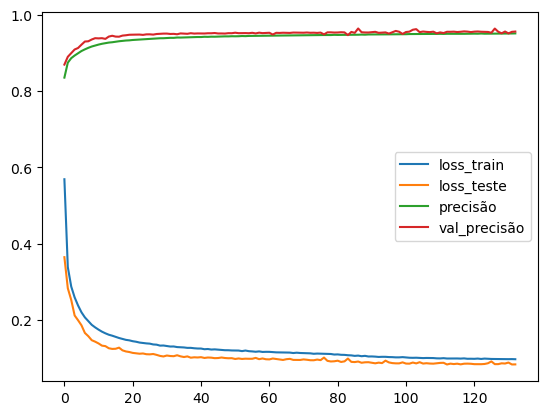

In [17]:
plt.plot(model_normal_sampli.history["loss"], label="loss_train")
plt.plot(model_normal_sampli.history["val_loss"], label="loss_teste")
plt.plot(model_normal_sampli.history["precision"], label="precisão")
plt.plot(model_normal_sampli.history["val_precision"], label="val_precisão")
#plt.plot(history.history["tp"], label="tp")
#plt.plot(history.history["val_tp"], label="val_tp")
plt.legend()

In [18]:

TrainPredictions = model_sampli.predict(X_test)
#convertendo dados onehot encoder para rotulos de classes
TrainPredictions_convert_samply = np.argmax(TrainPredictions, axis=1)
y_train_rotulos_samply = np.argmax(y_test_dump, axis=1)

7336/7336 [==============================] - 15s 2ms/step


Text(0.5, 23.52222222222222, 'Predicted label')

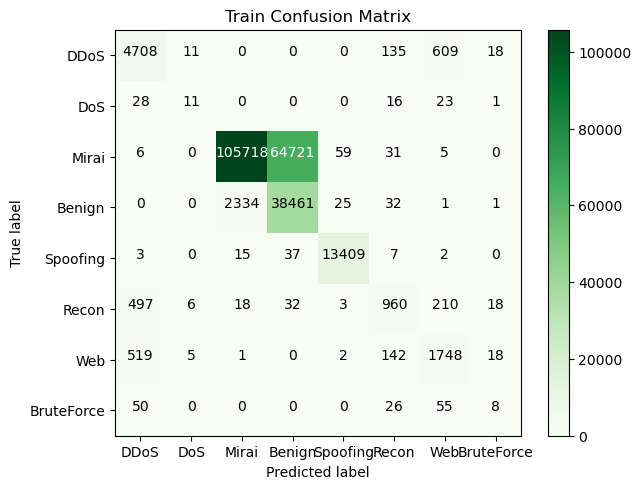

In [19]:
conf = confusion_matrix(y_train_rotulos_samply, TrainPredictions_convert_samply)

classes = ['DDoS', 'DoS','Mirai','Benign','Spoofing','Recon','Web','BruteForce']
#classes = [0,1,2,3,4,5,6,7]
#plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Train Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [21]:
print('Confusion Matrix\n')
print(conf)
#Micro: Foca no total agregado de verdadeiros positivos, falsos negativos e falsos positivos. Cada instância conta igualmente.
#importar as métricas 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(f'Accuracy: {accuracy_score(y_train_rotulos_samply, TrainPredictions_convert_samply)}\n')
print(f"Micro Precision: {precision_score(y_train_rotulos_samply, TrainPredictions_convert_samply, average='micro')}\n")
print(f"Micro Recall: {recall_score(y_train_rotulos_samply, TrainPredictions_convert_samply, average='micro')}\n")
print(f'Micro F1_score: {f1_score(y_train_rotulos_samply, TrainPredictions_convert_samply, average="micro")}\n')

#Macro: Calcula a métrica para cada classe individualmente e tira a média aritmética. Cada classe conta igualmente.
print(f'Macro Precision: {precision_score(y_train_rotulos_samply, TrainPredictions_convert_samply, average="macro")}\n')
print(f'Macro Recall: {recall_score(y_train_rotulos_samply, TrainPredictions_convert_samply, average="macro")}\n')
print(f'Macro F1_score: {f1_score(y_train_rotulos_samply, TrainPredictions_convert_samply, average="macro")}\n')

#Weighted: Calcula a métrica para cada classe individualmente e tira a média ponderada pelo número de instâncias em cada classe. Considera o desequilíbrio de classes.
print(f'Weighted Precision: {precision_score(y_train_rotulos_samply, TrainPredictions_convert_samply, average="weighted")}\n')
print(f'Weighted Recall: {recall_score(y_train_rotulos_samply, TrainPredictions_convert_samply, average="weighted")}\n')
print(f'Weighted F1_score: {f1_score(y_train_rotulos_samply, TrainPredictions_convert_samply, average="weighted")}\n')

#me tráz métricas de avaliação para modelos multiclasses
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_train_rotulos_samply, TrainPredictions_convert_samply,target_names= ['DDoS', 'DoS','Mirai','Benign','Spoofing','Recon','Web','BruteForce']))
#target_names= ['DDoS', 'DoS','Mirai','Benign','Spoofing','Recon','Web','BruteForce']
#target_names= ['0', '1','2','3','4','5','6','7']

Confusion Matrix

[[  4708     11      0      0      0    135    609     18]
 [    28     11      0      0      0     16     23      1]
 [     6      0 105718  64721     59     31      5      0]
 [     0      0   2334  38461     25     32      1      1]
 [     3      0     15     37  13409      7      2      0]
 [   497      6     18     32      3    960    210     18]
 [   519      5      1      0      2    142   1748     18]
 [    50      0      0      0      0     26     55      8]]
Accuracy: 0.7029883490596179

Micro Precision: 0.7029883490596179

Micro Recall: 0.7029883490596179

Micro F1_score: 0.7029883490596179

Macro Precision: 0.6228792346247424

Macro Recall: 0.6100827261549604

Macro F1_score: 0.5879931743933391

Weighted Precision: 0.86364274857046

Weighted Recall: 0.7029883490596179

Weighted F1_score: 0.7325879381357774


Classification Report

              precision    recall  f1-score   support

        DDoS       0.81      0.86      0.83      5481
         DoS      

In [22]:
model_smote = modeloDense(X_train,metricas)
model_normal_smote = model_smote.fit(X_train_smote, y_train_smote, validation_data=(X_validation_smote, y_validation_smote),
                  batch_size=500, epochs=200, verbose=1, callbacks=[Mycallback(), checkpoint_callback_modelsmote, callback_stop_patience])


Epoch 1/200
1986/1988 [============================>.] - ETA: 0s - loss: 0.5731 - fn: 306136.0000 - fp: 153665.0000 - Tn: 8784509.0000 - Tp: 970746.0000 - precision: 0.8633 - recall: 0.7602
Epoch 1: val_loss improved from inf to 0.42090, saving model to melhor_modelo1_smote.h5
1988/1988 [==============================] - 47s 23ms/step - loss: 0.5730 - fn: 306248.0000 - fp: 153733.0000 - Tn: 8788536.0000 - Tp: 971219.0000 - precision: 0.8633 - recall: 0.7603 - val_loss: 0.4209 - val_fn: 86574.0000 - val_fp: 59963.0000 - val_Tn: 2920798.0000 - val_Tp: 339249.0000 - val_precision: 0.8498 - val_recall: 0.7967
Epoch 2/200
1985/1988 [============================>.] - ETA: 0s - loss: 0.3660 - fn: 176604.0000 - fp: 122734.0000 - Tn: 6824766.0000 - Tp: 815896.0000 - precision: 0.8692 - recall: 0.8221
Epoch 2: val_loss improved from 0.42090 to 0.29671, saving model to melhor_modelo1_smote.h5
1988/1988 [==============================] - 49s 25ms/step - loss: 0.3659 - fn: 176755.0000 - fp: 122842.

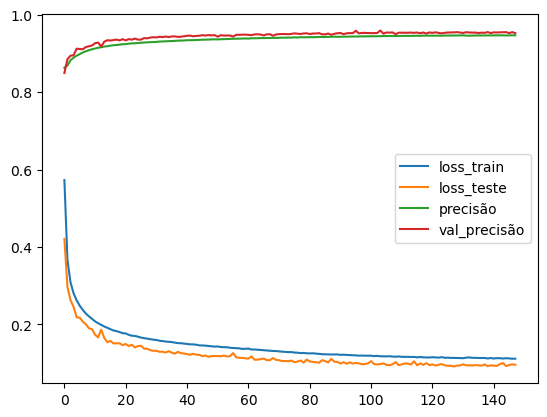

In [23]:
plt.plot(model_normal_smote.history["loss"], label="loss_train")
plt.plot(model_normal_smote.history["val_loss"], label="loss_teste")
plt.plot(model_normal_smote.history["precision"], label="precisão")
plt.plot(model_normal_smote.history["val_precision"], label="val_precisão")
#plt.plot(history.history["tp"], label="tp")
#plt.plot(history.history["val_tp"], label="val_tp")
plt.legend()

In [24]:

TrainPredictions_smote = model_smote.predict(X_test)
#convertendo dados onehot encoder para rotulos de classes
TrainPredictions_convert_smote = np.argmax(TrainPredictions_smote, axis=1)
y_train_rotulos_smote = np.argmax(y_test_dump, axis=1)

7336/7336 [==============================] - 15s 2ms/step


Text(0.5, 23.52222222222222, 'Predicted label')

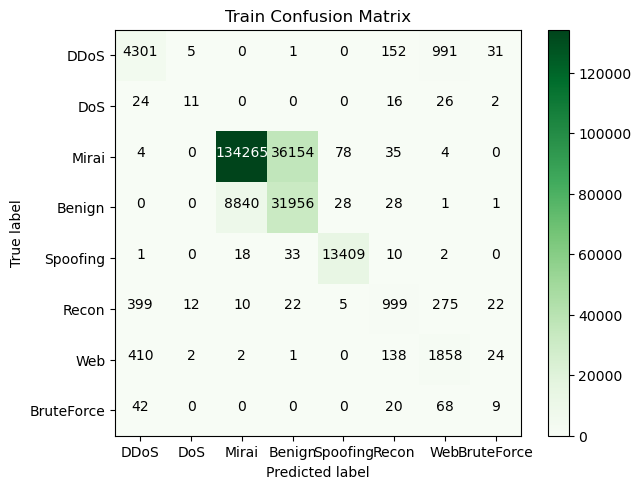

In [25]:
conf = confusion_matrix(y_train_rotulos_smote, TrainPredictions_convert_smote)

classes = ['DDoS', 'DoS','Mirai','Benign','Spoofing','Recon','Web','BruteForce']
#classes = [0,1,2,3,4,5,6,7]
#plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Train Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [26]:
print('Confusion Matrix\n')
print(conf)
#Micro: Foca no total agregado de verdadeiros positivos, falsos negativos e falsos positivos. Cada instância conta igualmente.
#importar as métricas 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(f'Accuracy: {accuracy_score(y_train_rotulos_smote, TrainPredictions_convert_smote)}\n')
print(f"Micro Precision: {precision_score(y_train_rotulos_smote, TrainPredictions_convert_smote, average='micro')}\n")
print(f"Micro Recall: {recall_score(y_train_rotulos_smote, TrainPredictions_convert_smote, average='micro')}\n")
print(f'Micro F1_score: {f1_score(y_train_rotulos_smote, TrainPredictions_convert_smote, average="micro")}\n')

#Macro: Calcula a métrica para cada classe individualmente e tira a média aritmética. Cada classe conta igualmente.
print(f'Macro Precision: {precision_score(y_train_rotulos_smote, TrainPredictions_convert_smote, average="macro")}\n')
print(f'Macro Recall: {recall_score(y_train_rotulos_smote, TrainPredictions_convert_smote, average="macro")}\n')
print(f'Macro F1_score: {f1_score(y_train_rotulos_smote, TrainPredictions_convert_smote, average="macro")}\n')

#Weighted: Calcula a métrica para cada classe individualmente e tira a média ponderada pelo número de instâncias em cada classe. Considera o desequilíbrio de classes.
print(f'Weighted Precision: {precision_score(y_train_rotulos_smote, TrainPredictions_convert_smote, average="weighted")}\n')
print(f'Weighted Recall: {recall_score(y_train_rotulos_smote, TrainPredictions_convert_smote, average="weighted")}\n')
print(f'Weighted F1_score: {f1_score(y_train_rotulos_smote, TrainPredictions_convert_smote, average="weighted")}\n')

#me tráz métricas de avaliação para modelos multiclasses
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_train_rotulos_smote, TrainPredictions_convert_smote,target_names= ['DDoS', 'DoS','Mirai','Benign','Spoofing','Recon','Web','BruteForce']))
#target_names= ['DDoS', 'DoS','Mirai','Benign','Spoofing','Recon','Web','BruteForce']
#target_names= ['0', '1','2','3','4','5','6','7']

Confusion Matrix

[[  4301      5      0      1      0    152    991     31]
 [    24     11      0      0      0     16     26      2]
 [     4      0 134265  36154     78     35      4      0]
 [     0      0   8840  31956     28     28      1      1]
 [     1      0     18     33  13409     10      2      0]
 [   399     12     10     22      5    999    275     22]
 [   410      2      2      1      0    138   1858     24]
 [    42      0      0      0      0     20     68      9]]
Accuracy: 0.795791177660866

Micro Precision: 0.795791177660866

Micro Recall: 0.795791177660866

Micro F1_score: 0.795791177660866

Macro Precision: 0.6234081928662608

Macro Recall: 0.6111628417532717

Macro F1_score: 0.6019800214101656

Weighted Precision: 0.8508306155475608

Weighted Recall: 0.795791177660866

Weighted F1_score: 0.8114666460219401


Classification Report

              precision    recall  f1-score   support

        DDoS       0.83      0.78      0.81      5481
         DoS       0.